In [1]:
import glob
import os
import pandas as pd
import re
import numpy as np
from pprint import pprint
import seaborn as sns
from statsmodels.tsa.stattools import adfuller  
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose  
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic

In [2]:
# Reading and normalizing csv containing the btc historial prices

btc_df = pd.read_csv("exported/investing.com/Bitcoin Historical Data - Investing.com.csv", usecols = ['Date','Price'])
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
btc_df['Date'] = btc_df['Date'].dt.normalize()
btc_df = btc_df.reset_index().set_index('Date')
btc_df = btc_df.drop(['index'], axis=1)
btc_df['Price'] = btc_df['Price'].str.replace(',', '')
btc_df['Price'] = btc_df['Price'].astype('float64')
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 2021-06-26 to 2020-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [3]:
btc_df.index.duplicated().any()

False

Text(0.5, 1.0, 'Box plot para preço do bitcoin')

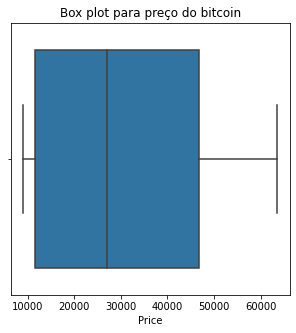

In [4]:
# Checking for outliers

plt.figure(figsize=(5, 5))
g = sns.boxplot(x=btc_df['Price'])  #realiza o plot através da biblioteca seaborn
g.set_title('Box plot para preço do bitcoin')

Text(0, 0.5, 'Preço')

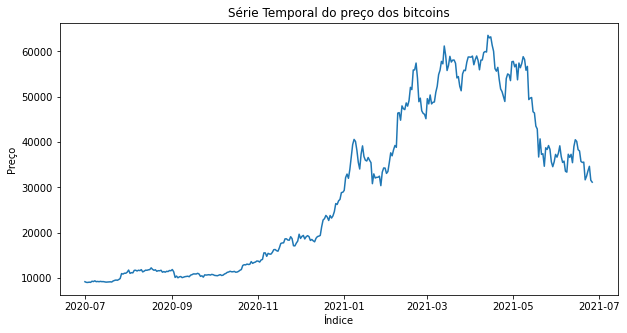

In [5]:
# Plot the Price TimeSeries

plt.figure(figsize=(10, 5))
g = sns.lineplot(x=btc_df.index,y=btc_df['Price'])
g.set_title('Série Temporal do preço dos bitcoins')
g.set_xlabel('Índice')
g.set_ylabel('Preço')

/home/prbpedro/Development/python_envs/tcc_puc/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/prbpedro/Development/python_envs/tcc_puc/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
sta

ARMA(p,q) = (6, 5) is the best.


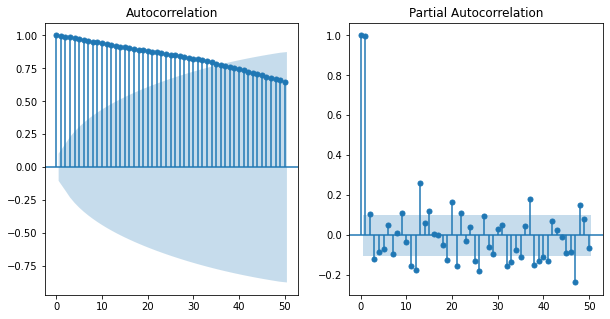

In [6]:
btc_df.dropna(inplace=True)

resDiff = arma_order_select_ic(btc_df, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(btc_df.values.squeeze(), lags=50, ax=ax[0])
plot_pacf(btc_df.values.squeeze(), lags=50, ax=ax[1])
plt.show()



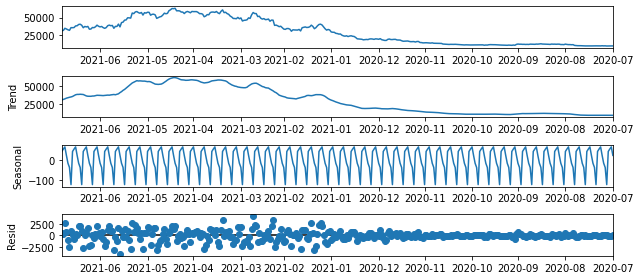

In [6]:
# plot the seasonal decompose series

decomposicao_aditiva = seasonal_decompose(btc_df, model='aditive',extrapolate_trend='freq')   

rcParams['figure.figsize'] = 9, 4
fig=decomposicao_aditiva.plot()  #realiza o plot da decomposição
plt.show()

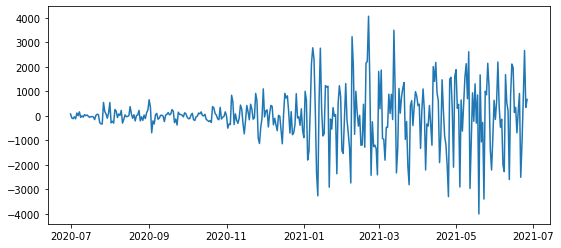

In [7]:
# Removing Trend

detrended = decomposicao_aditiva.resid + decomposicao_aditiva.seasonal
plt.plot(detrended)
plt.show()

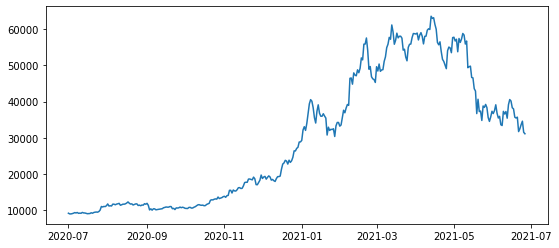

In [8]:
# Removing season

deseasonalized = decomposicao_aditiva.trend + decomposicao_aditiva.resid
plt.plot(deseasonalized)
plt.show()

In [9]:
resultado_ADF = adfuller(btc_df['Price'].values, autolag='AIC')

# < 0.05 stationary
# > 0.05 non stationary
print('ADF P-value:', resultado_ADF[1])

ADF P-value: 0.8844454842278063


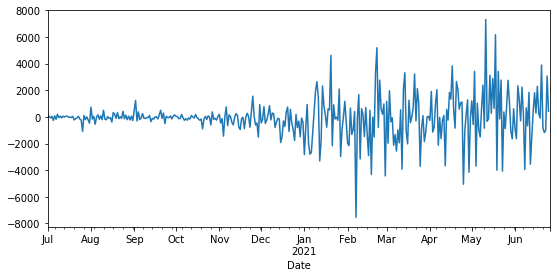

p-valor: 0.000003


In [10]:
# Making the series stationary

btc_df['Price'] = btc_df['Price'] - btc_df['Price'].shift(1)
btc_df['Price'].plot()
plt.show()  

X_diff = btc_df['Price'].dropna().values
resultado_primeira_diff = adfuller(X_diff)
print('p-valor: %f' % resultado_primeira_diff[1])

In [15]:
# Merging the btc historical price data with the sentimental analisys data
# Creating final csv file with Date, Score and Price columns

df = pd.read_csv("generated/btc_em_sentimental_analysis.csv", index_col='Date')
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)
btc_df.index = btc_df.index.tz_localize(None)
merged = pd.merge(df, btc_df, on = ['Date'], how = 'outer')

merged['Score'] = merged['Score'].fillna(0)
merged['Score'] = pd.to_numeric(merged['Score'])
merged['PositiveScore'] = merged['PositiveScore'].fillna(0)
merged['PositiveScore'] = pd.to_numeric(merged['PositiveScore'])
merged['NeutralScore'] = merged['NeutralScore'].fillna(0)
merged['NeutralScore'] = pd.to_numeric(merged['NeutralScore'])
merged['NegativeScore'] = merged['NegativeScore'].fillna(0)
merged['NegativeScore'] = pd.to_numeric(merged['NegativeScore'])
merged['Price'] = pd.to_numeric(merged['Price'])
merged.to_csv('generated/btc_value_em_tweets_sentimental_score.csv')

In [16]:
merged.head()

,Score,PositiveScore,NeutralScore,NegativeScore,Price
Date,,,,,
2021-06-13,0.8689,0.226,0.774,0.000,-1506.5
2021-06-04,-0.4215,0.000,0.517,0.483,1331.3
2021-05-24,0.6222,0.181,0.819,0.000,372.3
2021-05-22,0.4404,0.304,0.552,0.144,2768.6
2021-05-13,-0.0240,0.147,0.746,0.107,-135.2
